In [1]:
import awkward as ak
import numpy as np
import hist
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
from coffea.nanoevents import NanoEventsFactory, DelphesSchema
DelphesSchema.mixins["FatJet"] = "Jet"

In [2]:
samples = [
    {"name": "CMS", "model": "s-channel_mmed-1000_Nc-2_Nf-2_scale-35.1539_mq-10_mpi-20_mrho-20_pvector-0.75_spectrum-cms_rinv-0.3"},
    {"name": "Snowmass", "model": "s-channel_mmed-1000_Nc-3_Nf-3_scale-10_mq-10.119_mpi-6_mrho-25.0998_pvector-0.5_spectrum-snowmass_rinv-0.777778"},
    {"name": "Snowmass_cmslike", "model": "s-channel_mmed-1000_Nc-3_Nf-3_scale-33.3333_mq-33.73_mpi-20_mrho-83.666_pvector-0.5_spectrum-snowmass_rinv-0.3"}
]

In [40]:
# load data and metadata
import sys
sys.path.append('..')

from svjHelper import svjHelper
for sample in samples:
    path = f'../models/{sample["model"]}'
    sample["helper"] = svjHelper.build(f'{path}/config.py')
    metadict = sample["helper"].metadata()
    metadict["dataset"] = sample["name"]
    sample["events"] = NanoEventsFactory.from_root(     #To load data
        file=f'{path}/events.root',
        treepath="Delphes",
        schemaclass=DelphesSchema,
        metadata=metadict,
    ).events()

In [137]:
type(samples[0]["events"])

coffea.nanoevents.methods.base.NanoEventsArray

In [42]:
def normalize_angle(angle):
    
    # Normalize the angle to the range [0, 2*pi)
    angle = np.mod(angle, 2 * np.pi)
    
    # Shift the angle to the range [-pi, pi)
    angle = np.where(angle >= np.pi, angle - 2 * np.pi, angle)
    
    return angle

In [58]:
# apply basic selections and compute derived quantities
for sample in samples:
    events = sample["events"]
    
    # require two jets
    mask = ak.num(events.FatJet)>=2
    events = events[mask]
    
    # Dijet
    events["Dijet"] = events.FatJet[:,0]+events.FatJet[:,1]
    
    # 4-vectors for dijet
    events["Jet_pt"] = events.Dijet.pt
    events["Jet_eta"] = events.Dijet.eta
    events["Jet_phi"] = events.Dijet.phi
    events["Jet_mass"] = events.Dijet.mass
    
    events["MET"] = events.MissingET.MET
    
    # For plotting individually for jet1 and jet2
    
    leading_jets = events.FatJet[:, :2]

    # Create masks to identify which jet has the larger pt in each event
    jet1_mask = leading_jets[:, 0].pt >= leading_jets[:, 1].pt
    jet2_mask = ~jet1_mask

    # Assign jets to Jet1 and Jet2 based on the masks
    jet1 = ak.where(jet1_mask, leading_jets[:, 0], leading_jets[:, 1])
    jet2 = ak.where(jet2_mask, leading_jets[:, 0], leading_jets[:, 1])

    # Add these as new fields to the events array
    events["Jet1"] = jet1
    events["Jet2"] = jet2
    
    # 4-vectors for jet1 and jet2
    events["Jet1_pt"] = events["Jet1"].pt
    events["Jet2_pt"] = events["Jet2"].pt
    
    events["Jet1_eta"] = events["Jet1"].eta
    events["Jet2_eta"] = events["Jet2"].eta
    
    events["Jet1_phi"] = events["Jet1"].phi
    events["Jet2_phi"] = events["Jet2"].phi
    
    events["Jet1_mass"] = events["Jet1"].mass
    events["Jet2_mass"] = events["Jet2"].mass
    
    events["DeltaEta"] = np.abs(events["Jet2_eta"] - events["Jet1_eta"])
    events["DeltaPhi"] = np.abs(normalize_angle(events["Jet1_phi"] - events["Jet2_phi"]))
    
    #events["DeltaEta_MET_Jet1"] = np.abs(events.MissingET.eta - events["Jet1_eta"])
    #events["DeltaEta_MET_Jet2"] = np.abs(events.MissingET.eta - events["Jet2_eta"])
    
    events["DeltaPhi_MET_Jet1"] = np.abs(normalize_angle(events.MissingET.phi - events["Jet1_phi"]))
    events["DeltaPhi_MET_Jet2"] = np.abs(normalize_angle(events.MissingET.phi - events["Jet2_phi"]))
    
    # store modified events array
    sample["events"] = events

In [150]:
print(particles.fields)
print(events.fields)
print(events.FatJet.fields)
print(events.MissingET.fields)

['fUniqueID', 'fBits', 'PID', 'Status', 'IsPU', 'M1', 'M2', 'D1', 'D2', 'Charge', 'Mass', 'E', 'Px', 'Py', 'Pz', 'P', 'PT', 'Eta', 'Phi', 'Rapidity', 'T', 'X', 'Y', 'Z']
['Particle.offsets', 'Particle', 'Muon.offsets', 'Muon', 'EFlowNeutralHadron.offsets', 'EFlowNeutralHadron', 'Weight.offsets', 'Weight', 'Electron.offsets', 'Electron', 'GenFatJet.offsets', 'GenFatJet', 'GenMissingET.offsets', 'GenMissingET', 'EFlowPhoton.offsets', 'EFlowPhoton', 'EFlowTrack.offsets', 'EFlowTrack', 'Jet.offsets', 'Jet', 'Event.offsets', 'Event', 'Photon.offsets', 'Photon', 'GenJet.offsets', 'GenJet', 'MissingET.offsets', 'MissingET', 'FatJet.offsets', 'FatJet', 'Track.offsets', 'Track', 'Tower.offsets', 'Tower', 'ScalarHT.offsets', 'ScalarHT', 'Dijet', 'Jet_pt', 'Jet_eta', 'Jet_phi', 'Jet_mass', 'MET', 'DeltaEta', 'DeltaPhi', 'Jet1', 'Jet2', 'Jet1_pt', 'Jet2_pt', 'Jet1_eta', 'Jet2_eta', 'Jet1_phi', 'Jet2_phi', 'Jet1_mass', 'Jet2_mass', 'DeltaEta_MET_Jet1', 'DeltaEta_MET_Jet2', 'DeltaPhi_MET_Jet1', 'Del

In [5]:
# transverse mass calculation
events["Dijet"] = events.FatJet[:,0]+events.FatJet[:,1]
def ET(vec):
    return np.sqrt(vec.px**2+vec.py**2+vec.mass**2)
E1 = ET(events.Dijet)
E2 = events.MissingET.MET
MTsq = (E1+E2)**2-(events.Dijet.px+events.MissingET.px)**2-(events.Dijet.py+events.MissingET.py)
events["MT"] = np.sqrt(MTsq, where=MTsq>=0)

In [7]:
# Checking the columns of events
arr = [["events",samples[0]["events"]],["FatJet",samples[0]["events"].FatJet],["MissingET",samples[0]["events"].MissingET]]
for i in range(len(arr)):
    event = arr[i][1]
    print(f"Columns of {arr[i][0]}:\n")
    for field in event.fields:
        print(field)
    print("\n")  

Columns of events:

EFlowPhoton.offsets
EFlowPhoton
ScalarHT.offsets
ScalarHT
Weight.offsets
Weight
FatJet.offsets
FatJet
Track.offsets
Track
Muon.offsets
Muon
Event.offsets
Event
GenMissingET.offsets
GenMissingET
Photon.offsets
Photon
EFlowNeutralHadron.offsets
EFlowNeutralHadron
MissingET.offsets
MissingET
Particle.offsets
Particle
Tower.offsets
Tower
GenJet.offsets
GenJet
GenFatJet.offsets
GenFatJet
Electron.offsets
Electron
Jet.offsets
Jet
EFlowTrack.offsets
EFlowTrack
Dijet
Jet_pt
Jet_eta
Jet_phi
Jet_mass
MET


Columns of FatJet:

fUniqueID
fBits
PT
Eta
Phi
T
Mass
DeltaEta
DeltaPhi
Flavor
FlavorAlgo
FlavorPhys
TauFlavor
BTag
BTagAlgo
BTagPhys
TauTag
TauWeight
Charge
EhadOverEem
NCharged
NNeutrals
NeutralEnergyFraction
ChargedEnergyFraction
Beta
BetaStar
MeanSqDeltaR
PTD
FracPt_5
Tau_5
SoftDroppedJet
SoftDroppedSubJet1
SoftDroppedSubJet2
TrimmedP4_5
PrunedP4_5
SoftDroppedP4_5
NSubJetsTrimmed
NSubJetsPruned
NSubJetsSoftDropped
ExclYmerge12
ExclYmerge23
ExclYmerge34
ExclYmerge45
Excl

In [6]:
# helper functions to fill histograms

def get_values(var,sample):
    return ak.flatten(sample["events"][var],axis=None)

def fill_hist(var,nbins,bmin,bmax,label,samples):
    hists = {}
    for sample in samples:
        h = (
            hist.Hist.new
            .Reg(nbins, bmin, bmax, label=label)
            .Double()
        )
        h.fill(get_values(var,sample),weight=0.5)
        hists[sample["name"]] = h
    return hists

In [7]:
# stylistic options

mpl.rcParams.update({
    "axes.labelsize" : 18,
    "legend.fontsize" : 16,
    "xtick.labelsize" : 14,
    "ytick.labelsize" : 14,
    "font.size" : 18,
    "legend.frameon": True,
})
# based on https://github.com/mpetroff/accessible-color-cycles
# red, blue, mauve, orange, purple, gray, 
colors = ["#e42536", "#5790fc", "#964a8b", "#f89c20", "#7a21dd", "#9c9ca1"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

In [8]:
# helper to make a plot

def make_plot(hname,hists):
    fig, ax = plt.subplots(figsize=(8,6))
    for l,h in hists.items():
        hep.histplot(h,density=True,ax=ax,label=l)
    ax.set_xlim(h.axes[0].edges[0],h.axes[0].edges[-1])
    ax.set_yscale("log")
    ax.set_ylabel("Arbitury unit")
    ax.legend(framealpha=0.5)
    plt.savefig('../Histograms/{}.pdf'.format(hname),bbox_inches='tight')

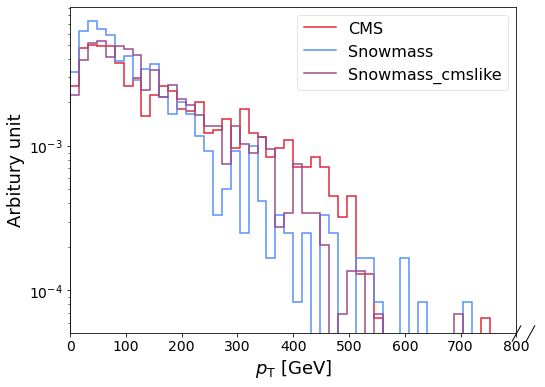

In [9]:
# plot transverse momentum
hists_pt = fill_hist("Jet_pt",50,0,800,r"$p_{\text{T}}$ [GeV]",samples)
make_plot("Jet_pt",hists_pt)

In [16]:
hists = [hists_pt, hists_pt1, hists_pt2]
type(hists[0]["CMS"])

hist.hist.Hist

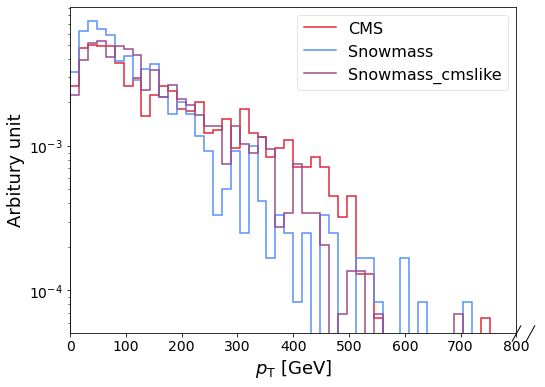

In [10]:
# plot transverse momentum
hists_pt1 = fill_hist("Jet1_pt",50,0,1000,r"$Jet_1\_p_{\text{T}}$ [GeV]",samples)
make_plot("Jet1_pt",hists_pt)

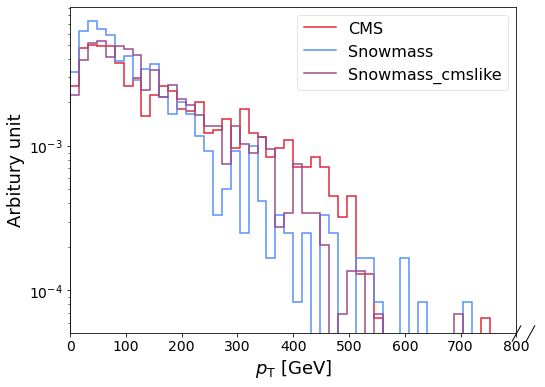

In [11]:
# plot transverse momentum
hists_pt2 = fill_hist("Jet2_pt",50,0,1000,r"$Jet_2\_p_{\text{T}}$ [GeV]",samples)
make_plot("Jet2_pt",hists_pt)

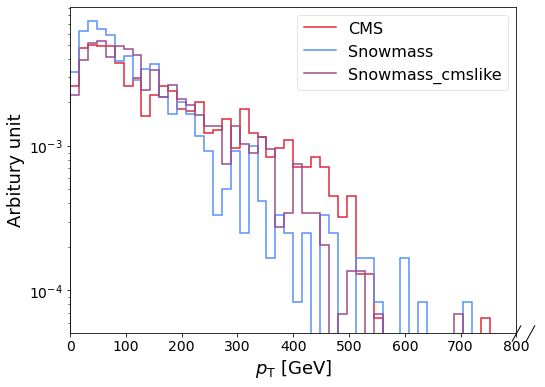

In [72]:
# plot missing transverse momentum
hists_met = fill_hist("MET",50,0,800,r"$p_{\text{T},miss}$ [GeV]",samples)
make_plot("MET",hists_pt)

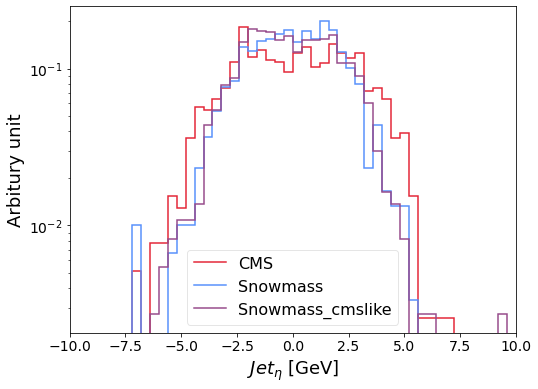

In [44]:
# plot jet_eta
hists_eta = fill_hist("Jet_eta",50,-10,10,r"$Jet_{\eta}$ [GeV]",samples)
make_plot("Jet_eta",hists_eta)

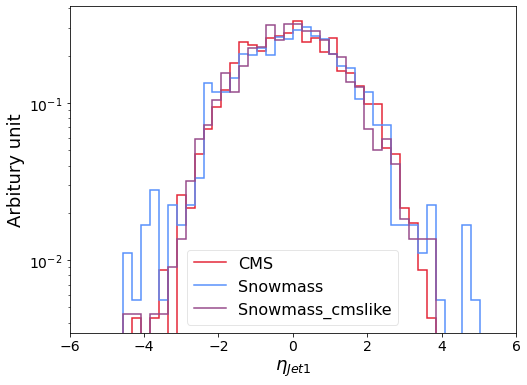

In [96]:
# plot jet1_eta
hists_eta = fill_hist("Jet1_eta",50,-6,6,r"$\eta_{Jet1}$",samples)
make_plot("Jet1_eta",hists_eta)

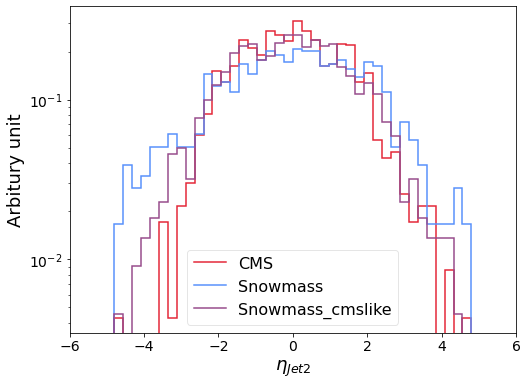

In [97]:
# plot jet2_eta
hists_eta = fill_hist("Jet2_eta",50,-6,6,r"$\eta_{Jet2}$",samples)
make_plot("Jet2_eta",hists_eta)

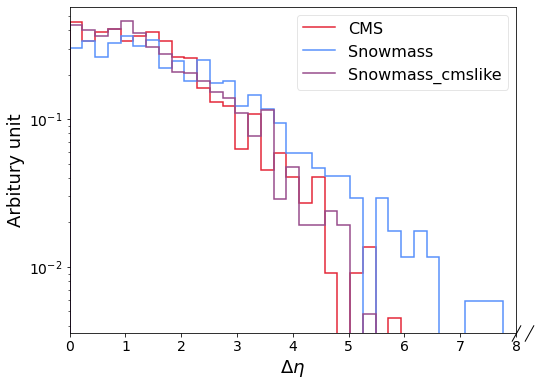

In [50]:
# plot del_jet_eta
hists_eta = fill_hist("DeltaEta",35,0,8.0,r"$\Delta\eta$",samples)
make_plot("DeltaEta",hists_eta)

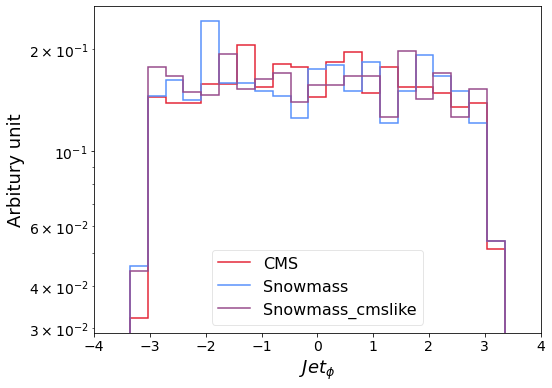

In [56]:
# plot jet_phi
hists_phi = fill_hist("Jet_phi",25,-4,4,r"$Jet_{\phi}$",samples)
make_plot("Jet_phi",hists_phi)

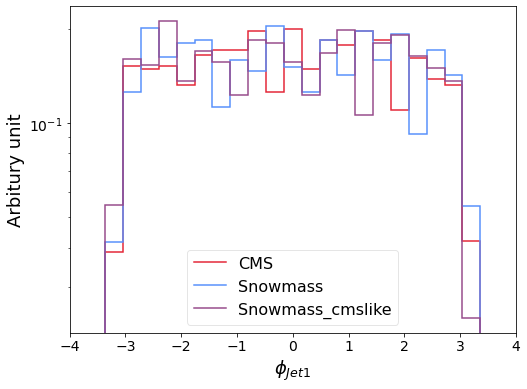

In [99]:
# plot jet1_phi
hists_phi = fill_hist("Jet1_phi",25,-4,4,r"$\phi_{Jet1}$",samples)
make_plot("Jet1_phi",hists_phi)

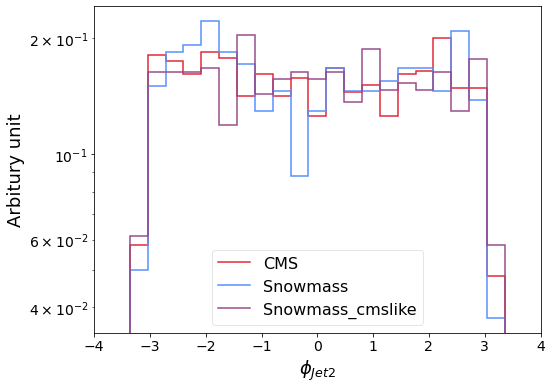

In [100]:
# plot jet2_phi
hists_phi = fill_hist("Jet2_phi",25,-4,4,r"$\phi_{Jet2}$",samples)
make_plot("Jet2_phi",hists_phi)

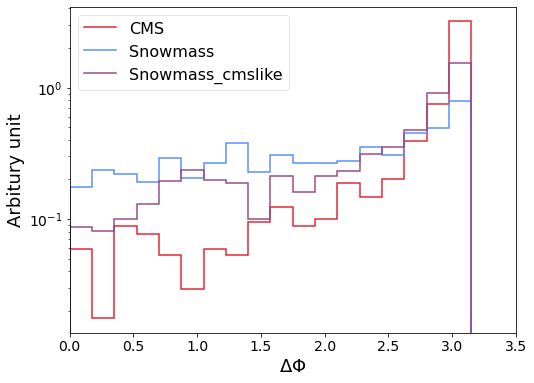

In [57]:
# plot DeltaPhi
hists_phi = fill_hist("DeltaPhi",20,0,3.5,r"$\Delta\Phi$",samples)
make_plot("DeltaPhi",hists_phi)

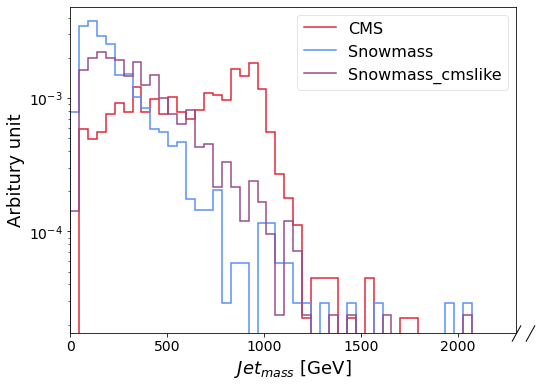

In [25]:
# plot jet_mass
hists_mass = fill_hist("Jet_mass",50,0,2300,r"$Jet_{mass}$ [GeV]",samples)
make_plot("Jet_mass",hists_mass)

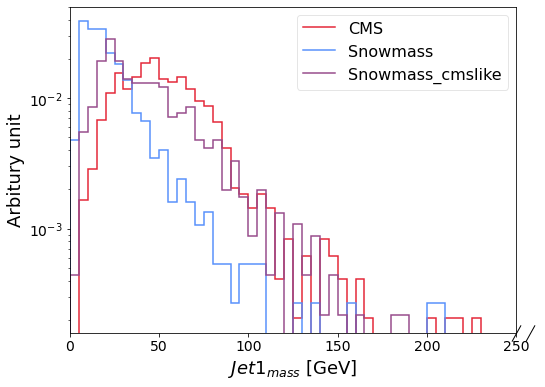

In [60]:
# plot jet1_mass
hists_mass = fill_hist("Jet1_mass",50,0,250,r"$Jet1_{mass}$ [GeV]",samples)
make_plot("Jet1_mass",hists_mass)

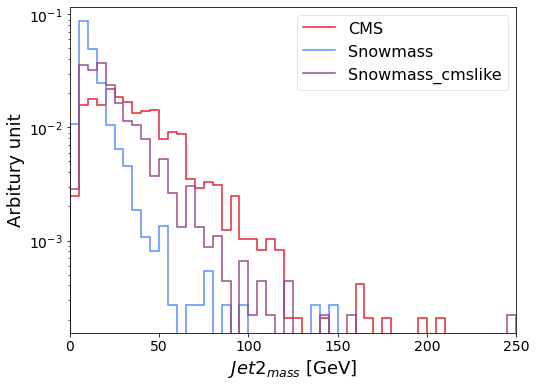

In [64]:
# plot jet2_mass
hists_mass = fill_hist("Jet2_mass",50,0,250,r"$Jet2_{mass}$ [GeV]",samples)
make_plot("Jet2_mass",hists_mass)

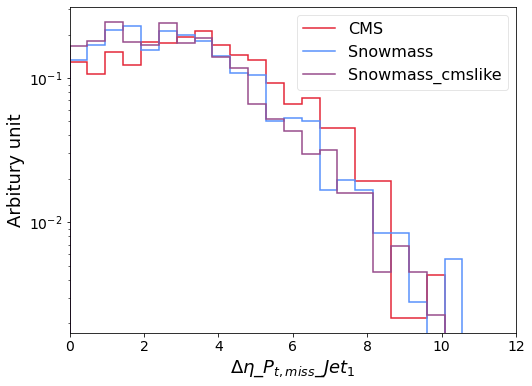

In [121]:
# plot delta_eta between MET and jet1
hists_eta = fill_hist("DeltaEta_MET_Jet1",25,0,12,r"$\Delta\eta\_P_{t,miss}\_Jet_1$",samples)
make_plot("DeltaEta_MET_Jet1",hists_eta)

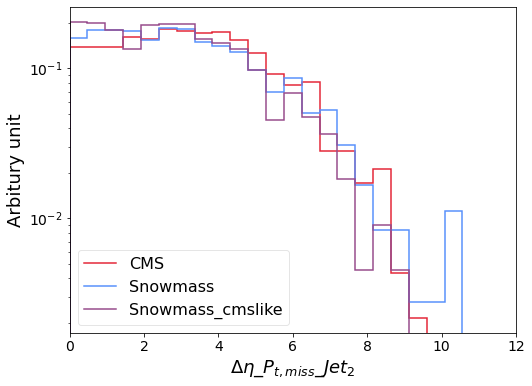

In [122]:
# plot delta_eta between MET and jet2
hists_eta = fill_hist("DeltaEta_MET_Jet2",25,0,12,r"$\Delta\eta\_P_{t,miss}\_Jet_2$",samples)
make_plot("DeltaEta_MET_Jet2",hists_eta)

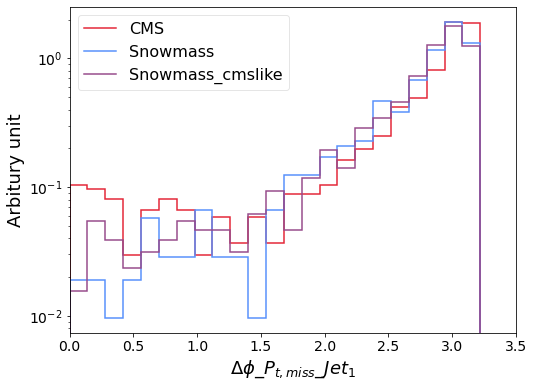

In [60]:
# plot delta_phi between MET and jet1
hists_phi = fill_hist("DeltaPhi_MET_Jet1",25,0,3.5,r"$\Delta\phi\_P_{t,miss}\_Jet_1$",samples)
make_plot("DeltaPhi_MET_Jet1",hists_phi)

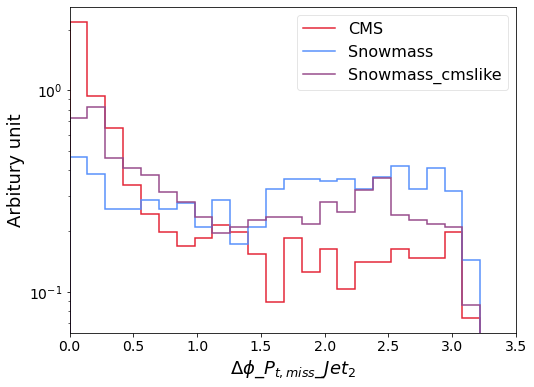

In [62]:
# plot delta_phi between MET and jet2
hists_phi = fill_hist("DeltaPhi_MET_Jet2",25,0,3.5,r"$\Delta\phi\_P_{t,miss}\_Jet_2$",samples)
make_plot("DeltaPhi_MET_Jet2",hists_phi)

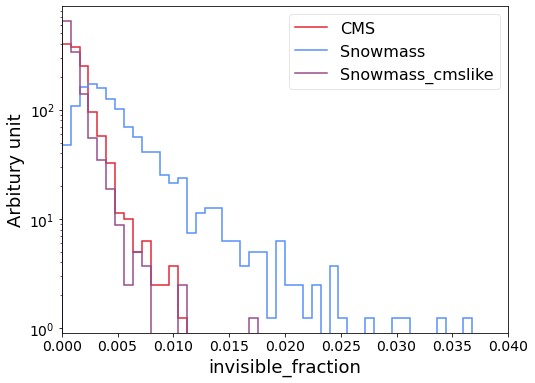

In [127]:
# plot invisible fraction
hists_if = fill_hist("invisible_fraction",50,0,0.04,r"invisible_fraction",samples)
make_plot("invisible_fraction",hists_if)

# Test for histogram automation

In [66]:
hists_cms = [hists_pt["CMS"], hists_pt1["CMS"], hists_pt2["CMS"]]
hists_snowmass = [hists_pt["Snowmass"], hists_pt1["Snowmass"], hists_pt2["Snowmass"]]
hists_snowmass_cms = [hists_pt["Snowmass_cmslike"], hists_pt1["Snowmass_cmslike"], hists_pt2["Snowmass_cmslike"]]
print(hists_cms[0])
type(hists_cms[0])

                 ┌───────────────────────────────────────────────────────────┐
[-inf,   0) 0    │                                                           │
[   0,  16) 20   │██████████████████████████████▏                            │
[  16,  32) 37   │███████████████████████████████████████████████████████▊   │
[  32,  48) 38.5 │██████████████████████████████████████████████████████████ │
[  48,  64) 38   │█████████████████████████████████████████████████████████▎ │
[  64,  80) 38   │█████████████████████████████████████████████████████████▎ │
[  80,  96) 29   │███████████████████████████████████████████▊               │
[  96, 112) 20   │██████████████████████████████▏                            │
[ 112, 128) 23   │██████████████████████████████████▋                        │
[ 128, 144) 12.5 │██████████████████▉                                        │
[ 144, 160) 17.5 │██████████████████████████▍                                │
[ 160, 176) 20   │██████████████████████████████▏   

hist.hist.Hist

In [22]:
import pickle
# Saving the histograms and Events
# save the histograms    
with open("save_hists.pickle", "w") as out:
    for item in hists:            
        pickle.dumps(item, out)

# open another file Events.json to store the events
open("Events.json", "w").write(ak.to_json(Events))

# open the file to read the events    
Events = ak.from_json(open("../Saved files/Events.json").read())

TypeError: an integer is required (got type _io.TextIOWrapper)

In [34]:
import pickle

with open("../Save_hist/cms_hists.pkl", "wb") as out:
    for item in hists_cms:            
        pickle.dump(item, out)

with open("../Save_hist/snowmass_hists.pkl", "wb") as out:
    for item in hists_snowmass:            
        pickle.dump(item, out)

with open("../Save_hist/snowmass_cms_hists.pkl", "wb") as out:
    for item in hists_snowmass_cms:            
        pickle.dump(item, out)

In [32]:
# Retrieve the histograms and Events
# open the file to read the histograms
hists_cms_in = []    
with open("../Save_hist/cms_hists.pkl", "rb") as inp:
    while True:            
        try:
            hists_cms_in.append(pickle.load(inp))            
        except EOFError:
            break

hists_snow_in = []    
with open("../Save_hist/snowmass_hists.pkl", "rb") as inp:
    while True:            
        try:
            hists_snow_in.append(pickle.load(inp))            
        except EOFError:
            break
            
hists_snowcms_in = []    
with open("../Save_hist/snowmass_cms_hists.pkl", "rb") as inp:
    while True:            
        try:
            hists_snowcms_in.append(pickle.load(inp))            
        except EOFError:
            break
            
            
hists_in_pt = {"CMS":hists_cms_in[0], "Snowmass":hists_snow_in[0], "Snowmass_cms_like":hists_snowcms_in[0]}

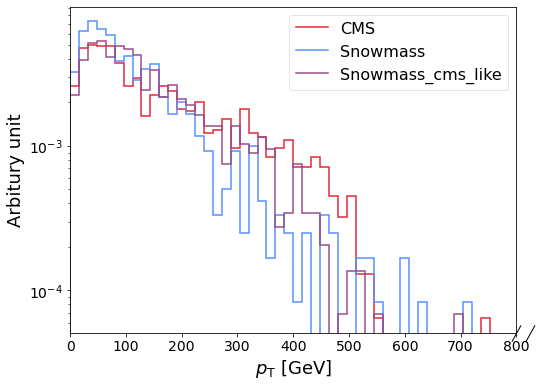

In [33]:
make_plot("Jet_pt",hists_in_pt)

In [78]:
hnames = ["Jet_pt", "Jet1_pt", "Jet2_pt"]
hists = [hists_pt, hists_pt1, hists_pt2]

# Create a dictionary using zip
hist_dict = {
    "Jet_pt":hists_pt,
    "Jet_pt1":hists_pt1,
    "Jet_pt2":hists_pt2
}

# Print the resulting dictionary
print(hist_dict)

{'Jet_pt': {'CMS': Hist(Regular(50, 0, 800, label='$p_{\\text{T}}$ [GeV]'), storage=Double()) # Sum: 484.5, 'Snowmass': Hist(Regular(50, 0, 800, label='$p_{\\text{T}}$ [GeV]'), storage=Double()) # Sum: 374.0, 'Snowmass_cmslike': Hist(Regular(50, 0, 800, label='$p_{\\text{T}}$ [GeV]'), storage=Double()) # Sum: 458.0 (458.5 with flow)}, 'Jet_pt1': {'CMS': Hist(Regular(50, 0, 1000, label='$Jet_1\\_p_{\\text{T}}$ [GeV]'), storage=Double()) # Sum: 484.0 (484.5 with flow), 'Snowmass': Hist(Regular(50, 0, 1000, label='$Jet_1\\_p_{\\text{T}}$ [GeV]'), storage=Double()) # Sum: 374.0, 'Snowmass_cmslike': Hist(Regular(50, 0, 1000, label='$Jet_1\\_p_{\\text{T}}$ [GeV]'), storage=Double()) # Sum: 457.5 (458.5 with flow)}, 'Jet_pt2': {'CMS': Hist(Regular(50, 0, 1000, label='$Jet_2\\_p_{\\text{T}}$ [GeV]'), storage=Double()) # Sum: 484.5, 'Snowmass': Hist(Regular(50, 0, 1000, label='$Jet_2\\_p_{\\text{T}}$ [GeV]'), storage=Double()) # Sum: 374.0, 'Snowmass_cmslike': Hist(Regular(50, 0, 1000, label='$

In [87]:
hist_dict.keys()
hnames = []
for key in hist_dict.keys():
    hnames.append(key)
hists = []
for value in hist_dict.values():
    hists.append(value)
hists

[{'CMS': Hist(Regular(50, 0, 800, label='$p_{\\text{T}}$ [GeV]'), storage=Double()) # Sum: 484.5,
  'Snowmass': Hist(Regular(50, 0, 800, label='$p_{\\text{T}}$ [GeV]'), storage=Double()) # Sum: 374.0,
  'Snowmass_cmslike': Hist(Regular(50, 0, 800, label='$p_{\\text{T}}$ [GeV]'), storage=Double()) # Sum: 458.0 (458.5 with flow)},
 {'CMS': Hist(Regular(50, 0, 1000, label='$Jet_1\\_p_{\\text{T}}$ [GeV]'), storage=Double()) # Sum: 484.0 (484.5 with flow),
  'Snowmass': Hist(Regular(50, 0, 1000, label='$Jet_1\\_p_{\\text{T}}$ [GeV]'), storage=Double()) # Sum: 374.0,
  'Snowmass_cmslike': Hist(Regular(50, 0, 1000, label='$Jet_1\\_p_{\\text{T}}$ [GeV]'), storage=Double()) # Sum: 457.5 (458.5 with flow)},
 {'CMS': Hist(Regular(50, 0, 1000, label='$Jet_2\\_p_{\\text{T}}$ [GeV]'), storage=Double()) # Sum: 484.5,
  'Snowmass': Hist(Regular(50, 0, 1000, label='$Jet_2\\_p_{\\text{T}}$ [GeV]'), storage=Double()) # Sum: 374.0,
  'Snowmass_cmslike': Hist(Regular(50, 0, 1000, label='$Jet_2\\_p_{\\text{

In [21]:
hists = {'cms' : {'pt':1, 'pt1':2, 'pt3':3},
        'snow': {'pt':4, 'pt1':5, 'pt3':6},
        'snow_cms': {'pt':7, 'pt1':8, 'pt3':9}}

for l,h in hists.items():
    print(h['pt'])
    
hnames = hists['cms'].keys()
print(hnames)
hnames = []
for key in hists['cms']:
    hnames.append(key)
hnames

1
4
7
dict_keys(['pt', 'pt1', 'pt3'])


['pt', 'pt1', 'pt3']